In [1]:
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
df1 = pd.read_csv("~/Downloads/Bengaluru_House_Data.csv")
df2 = df1.drop(['area_type', 'society', 'balcony','availability'], axis = 'columns')

In [3]:
df3 = df2.dropna()


In [4]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

/tmp/ipykernel_5301/2222900254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [5]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df4 = df3[df3['total_sqft'].apply(is_float)]

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    
    try:
        return float(x)
    
    except:
        return None
    
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num) 

In [6]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']

In [7]:
df5.location = df5.location.apply(lambda x: x.strip())

In [8]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending = False)

In [9]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
df5.location = df5.location.apply( lambda x: 'other' if x in location_stats_less_than_10 else x)


In [10]:
df6 = df5[~(df5.total_sqft/df5.bhk < 300) ]

In [11]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [12]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out

df7 = remove_pps_outliers(df6)
df7.shape

(10241, 10)

In [13]:
df7.columns

Index(['location', 'size', 'total_sqft', 'bath', 'year_built', 'Address',
       'up_for_sale_year', 'price', 'bhk', 'price_per_sqft'],
      dtype='object')

In [14]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label='2 BHK', s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green',label = '3 BHK', s=50)
    plt.xlabel("Total Square")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend();
    


In [15]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')
                                                                    
df8 = remove_bhk_outliers(df7)

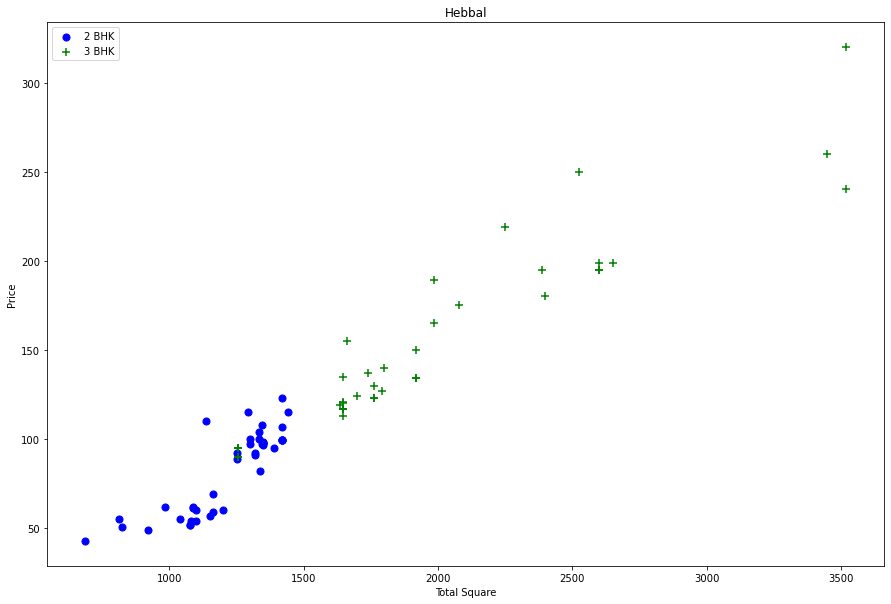

In [16]:
plot_scatter_chart(df8, "Hebbal")

In [17]:
df8.columns


Index(['location', 'size', 'total_sqft', 'bath', 'year_built', 'Address',
       'up_for_sale_year', 'price', 'bhk', 'price_per_sqft'],
      dtype='object')

In [18]:
df9 = df8.drop(['year_built', 'Address', 'up_for_sale_year'], axis = 1)

In [19]:
df9.shape

(7329, 7)

(array([4.766e+03, 1.763e+03, 6.780e+02, 8.100e+01, 2.900e+01, 7.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

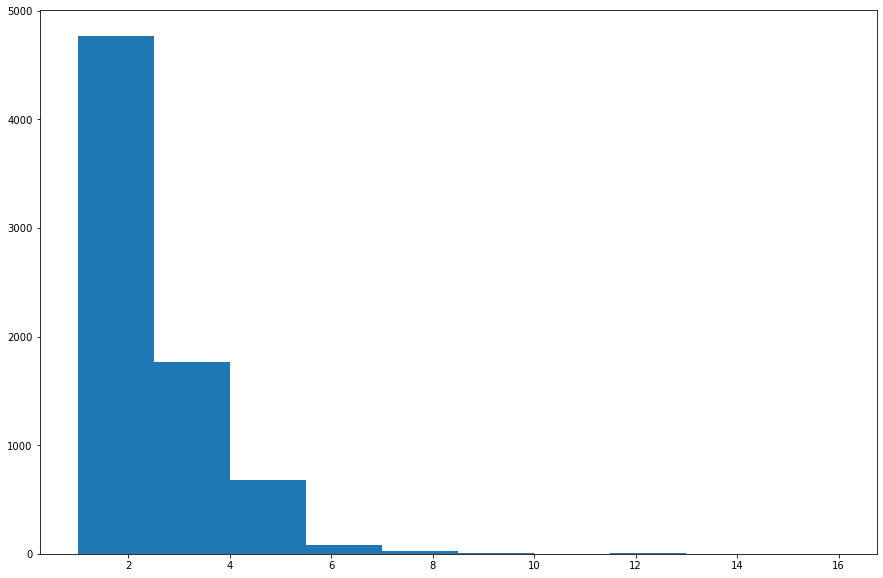

In [20]:
plt.hist(df8.bath, rwidth = 1)

In [21]:
df10 = df9[df9.bath < df9.bhk + 2]

In [22]:
df10.shape

(7251, 7)

In [23]:
df11 = df10.drop(['size', 'price_per_sqft'], axis = 'columns')

In [24]:
df11

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10232,other,1200.0,2.0,70.0,2
10233,other,1800.0,1.0,200.0,1
10236,other,1353.0,2.0,110.0,2
10237,other,812.0,1.0,26.0,1


In [25]:
dummies = pd.get_dummies(df11.location)
df12 = pd.concat([df11, dummies.drop(['other'], axis='columns')], axis='columns')

In [26]:
df12 = df12.drop(['location'], axis='columns')

In [27]:
df12.shape

(7251, 245)

In [28]:
x = df12.drop('price', axis='columns')

In [29]:
y = df12.price

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10)

In [31]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.845227769787428

In [32]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [33]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(x, y):
    
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
    

find_best_model_using_gridsearchcv(x, y)

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipel

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': False}
1,lasso,0.687539,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.716064,"{'criterion': 'mse', 'splitter': 'best'}"


In [34]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr_clf.predict([x])[0]

In [35]:
predict_price('1st Phase JP Nagar', 100000, 3, 3)

NameError: name 'X' is not defined

In [36]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

In [38]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))